In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/final_dataset_teacher.zip

Archive:  /content/drive/MyDrive/final_dataset_teacher.zip
  inflating: benchmark_dataset.csv   
  inflating: benchmark_dataset_semi_supervised.csv  
  inflating: final_complete_teacher_dataset.csv  
  inflating: final_dataset_teacher.csv  
  inflating: final_dataset_teacher_semi_supervised.csv  


In [ ]:
# Importing libraries and modules
import numpy as np
import pandas as pd
import scipy
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, cut_tree, set_link_color_palette, dendrogram
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.semi_supervised import LabelSpreading, SelfTrainingClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import random

In [ ]:
# Reading the first dataset and dropping irrelevant columns
df = pd.read_csv("benchmark_dataset_semi_supervised.csv")
df1 = df.drop(df.columns[[0, 1, 12]], axis=1)

X1 = df1.iloc[:, :-1].values
y1 = df.iloc[:, -1].values

In [ ]:
# Reading the second dataset and dropping irrelevant columns
d = pd.read_csv("final_dataset_teacher_semi_supervised.csv")
df = d.drop(d.columns[[0, 1, 12]], axis=1)

X = df[['q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'q10']].to_numpy()
y = df.iloc[:, -1].values

In [ ]:
X_labeled, X_unlabeled, y_labeled, _ = train_test_split(X, y, test_size=0.3, stratify=y)

In [ ]:
X1_labeled, X1_unlabeled, y1_labeled, _ = train_test_split(X1, y1, test_size=0.3, stratify=y1)
X1_labeled = X1_labeled[:, :-1]
eval_y = X1_unlabeled[:, -1]
X1_unlabeled = X1_unlabeled[:, :-1]

In [ ]:
# Creating the SVM classifier
clf = SVC(kernel='linear', C=100, probability=True)

In [ ]:
self_model = SelfTrainingClassifier(clf)
self_model.fit(X_labeled, y_labeled)

SelfTrainingClassifier(base_estimator=SVC(C=100, kernel='linear',
                                          probability=True))

In [ ]:
# Predict categories for all teachers
predicted_categories = self_model.predict(X)

In [ ]:
# Fitting the SVM model to the entire second dataset only on the first two features
self_model.fit(X[:,:2], y)

SelfTrainingClassifier(base_estimator=SVC(C=100, kernel='linear',
                                          probability=True))

In [ ]:
# Defining the maximum and minimum values of the first two features
x_min, x_max = X[:, 0]. min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 0]. min() - 1, X[:, 1].max() + 1

# Creating a meshgrid spanning the range of training data
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02),
                     np.arange(y_min, y_max, .02))

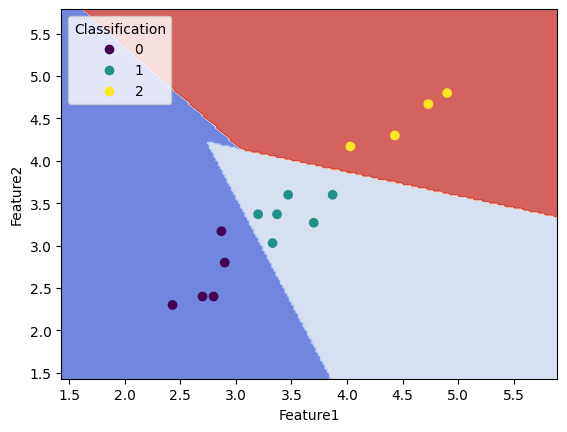

In [ ]:
# Predicting the label for each point in the meshgrid
Z = self_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plotting decision boundary as a contour plot
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

# Plotting the training data as scatter points
scat=plt.scatter(X[:, 0], X[:, 1], c=predicted_categories)
legend1=plt.legend(*scat.legend_elements(),
                   loc="upper left", title="Classification")

plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

# Displaying the plot
plt.show()

In [ ]:
def get_cat(num):
  if num < 3:
    return "Poor"
  elif num >=3 and num < 4:
    return "Mediocre"
  else:
    return "Excellent"

In [ ]:
# Assign categories based on cluster membership and performance
categories = [(predicted_categories[i] + 1) for i in range(len(predicted_categories))]
fin_cat = [(predicted_categories[i]) for i in range(len(predicted_categories))]
avgs1 = d["average"]
s1, s2, s3 = 0, 0, 0
c1, c2, c3 = 0, 0, 0
p = 0
for c in categories:
  if c == 1:
    s1 += avgs1[p]
    c1 += 1
  elif c == 2:
    s2 += avgs1[p]
    c2 += 1
  else:
    s3 += avgs1[p]
    c3 += 1
  p += 1
avg1 = s1/c1
avg2 = s2/c2
avg3 = s3/c3
cat1 = get_cat(avg1)
cat2 = get_cat(avg2)
cat3 = get_cat(avg3)
for i in range(len(categories)):
  if categories[i] == 1:
    categories[i] = cat1
  elif categories[i] == 2:
    categories[i] = cat2
  else:
    categories[i] = cat3

In [ ]:
# Add new column with category to the original data
d["category"] = categories
print(d[["faculty_id", "category"]].to_string())

   faculty_id   category
0           A       Poor
1           B       Poor
2           C       Poor
3           D   Mediocre
4           E  Excellent
5           F   Mediocre
6           G  Excellent
7           H  Excellent
8           I   Mediocre
9           J   Mediocre
10          K   Mediocre
11          L   Mediocre
12          M       Poor
13          N       Poor
14          O  Excellent


In [ ]:
self_model.fit(X1_labeled, y1_labeled)

SelfTrainingClassifier(base_estimator=SVC(C=100, kernel='linear',
                                          probability=True))

In [ ]:
predicted_cats = self_model.predict(X1_unlabeled)

In [ ]:
# Calculate F1-score
f1 = f1_score(eval_y, predicted_cats, average='weighted')

In [ ]:
print(f"F1-score: {f1}")

F1-score: 0.9733415511042629
